Nice plots for Drell-Yan stitching cross-check
To be used with PyROOT (so in a cmsenv)

In [3]:
import os
import uproot
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
import hist
import hist.plot
import hist.intervals
import json
import ROOT

Welcome to JupyROOT 6.24/07


In [2]:
njets_names = [f"dy_{bin}j" for bin in range(0, 3)]
ptz_names = [f"dy_ptz{bin}" for bin in range(1, 7)]

In [45]:
def plot_detailed(folder_stitched, folder_notStitched, suffix=""):
    dir_stitched = uproot.open(f"{folder_stitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root:histograms")
    dir_incl = uproot.open(f"{folder_notStitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root:histograms")
    
    fig, main_ax = plt.subplots()

    hep.histplot([dir_stitched["dy_incl"]] + [dir_stitched[name] for name in njets_names] + [dir_stitched[name] for name in ptz_names], yerr=False,
                 label=["Inclusive (stitched)"] + [f"Njets bin {bin}" for bin in range(len(njets_names))] + [f"PtZ bin {bin}" for bin in range(1, 9)],  ax=main_ax, stack=True)
    # njets_binned_artists = hep.histplot([dir_stitched[name] for name in njets_names], yerr=True, label=[f"Njets bin {bin}" for bin in range(1, 9)], flow="none", ax=main_ax)
    # ptz_binned_artists = hep.histplot([dir_stitched[name] for name in ptz_names], yerr=True, label=[f"PtZ bin {bin}" for bin in range(1, 9)], flow="none", ax=main_ax)
    incl_artists = hep.histplot(dir_incl["dy_incl"], label="Inclusive (unstitched)", yerr=True, histtype="errorbar", color="black", markersize=5, ax=main_ax)

    main_ax.set_yscale("log")
    main_ax.set_ylim(bottom=1)
    if suffix == "":
        plt.xlim(0, 1e3)
    main_ax.legend()
    #main_ax.legend(incl_artists + ht_binned_artists, ["Inclusive"] + [f"HT bin {bin}" for bin in range(1, 9)])
    main_ax.set_xlabel("$p_T^Z$ (GeV)")
    main_ax.set_ylabel("Events")
    hep.cms.text("Simulation Preliminary", fontsize=25, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, 13 TeV (${lumi/ 1000:.1f}\/""fb^{-1}$)", fontsize=20, ax=main_ax)

def make_root_hist(folder_stitched, folder_notStitched):
    dir_stitched = ROOT.TFile(f"{folder_stitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root")
    dir_incl = ROOT.TFile(f"{folder_notStitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root")
    h_stitched = dir_stitched.Get("histograms/dy_incl")

    for name in njets_names + ptz_names:
        h_stitched.Add(dir_stitched.Get(f"histograms/{name}"))
    
    h_incl = dir_incl.Get("histograms/dy_incl")

    ratio = h_stitched.Clone()
    ratio.Divide(h_incl)
    ratio.SetDirectory(ROOT.nullptr)
    h_stitched.SetDirectory(ROOT.nullptr)
    h_incl.SetDirectory(ROOT.nullptr)
    return h_stitched, h_incl, ratio

def plot_ratio(folder_stitched, folder_notStitched, suffix=""):
    # dir_stitched = uproot.open(f"{folder_stitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root:histograms")
    # dir_incl = uproot.open(f"{folder_notStitched}/root/LHE_Vpt__os_iso__pg_dy_split__nodata.root:histograms")

    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    stitched_h, inclusive_h, ratio_h = make_root_hist(folder_stitched, folder_notStitched)
    #stitched_h = sum([dir_stitched["dy_incl"].to_hist()] + [dir_stitched[name].to_hist() for name in njets_names] + [dir_stitched[name].to_hist() for name in ptz_names])
    stitched_artist = hep.histplot(uproot.from_pyroot(stitched_h), yerr=True, label="Stitched", ax=main_ax)
    #inclusive_h = dir_incl["dy_incl"].to_hist()
    incl_artist = hep.histplot(uproot.from_pyroot(inclusive_h), label="Inclusive", yerr=True, histtype="errorbar", color="black", markersize=5, ax=main_ax)

    # with np.errstate(divide="ignore", invalid="ignore"):
    #     # this uncertainty looks wrong 
    #     errors_sq = (stitched_h.variances()*inclusive_h.values()*inclusive_h.values() + inclusive_h.variances()*stitched_h.values()*stitched_h.values())/np.power(inclusive_h.values()*inclusive_h.values(), 4)
    #     ratio = stitched_h.values() / inclusive_h.values()
    print(uproot.from_pyroot(inclusive_h))
    hist.plot.plot_ratio_array(uproot.from_pyroot(inclusive_h).to_hist(), uproot.from_pyroot(ratio_h).values(), np.sqrt(uproot.from_pyroot(ratio_h).variances()), subplot_ax, ylim=(0.8,1.2), markersize=5)

    main_ax.set_yscale("log")
    main_ax.set_ylim(bottom=1)
    subplot_ax.set_ylim(0.5, 1.5)
    if suffix == "":
        plt.xlim(0, 1e3)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.legend(incl_artist + stitched_artist, ["Inclusive", "Stitched"])
    main_ax.set_xlabel("")
    subplot_ax.set_xlabel("LHE $p_T^Z$ (GeV)")
    subplot_ax.grid(axis="y", which="both")
    subplot_ax.set_ylabel("Stitched/Inclusive", size=20)
    main_ax.set_ylabel("Events")
    hep.cms.text("Simulation Preliminary", fontsize=25, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, 13 TeV (${lumi/ 1000:.1f}\/""fb^{-1}$)", fontsize=20, ax=main_ax)

/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-mplhep/0.3.12-8db088fc4d199ed31f890185ac26ddfc/lib/python3.9/site-packages/mplhep/plot.py:247: RuntimeWarning: invalid value encountered in sqrt
  _yerr = np.sqrt(h)
/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-mplhep/0.3.12-8db088fc4d199ed31f890185ac26ddfc/lib/python3.9/site-packages/mplhep/plot.py:247: RuntimeWarning: invalid value encountered in sqrt
  _yerr = np.sqrt(h)


<TH1D (version 3) at 0x7f770668bf70>


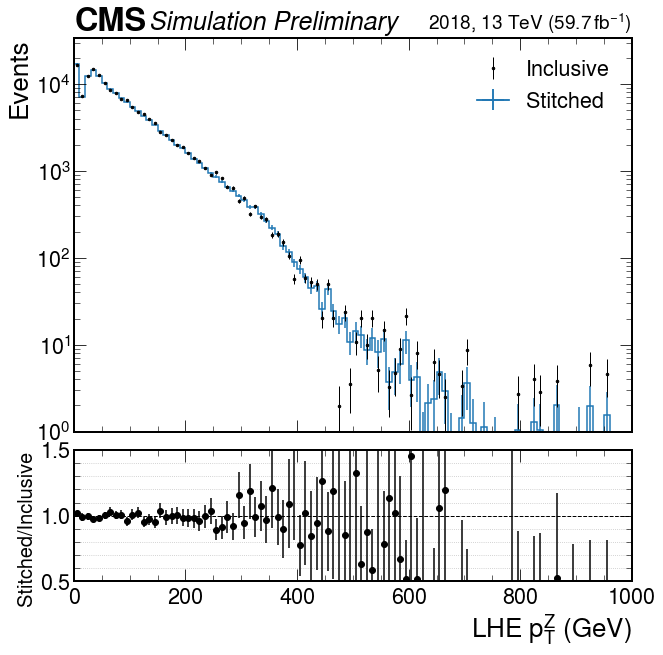

In [43]:
plot_ratio(folder_stitched="/grid_mnt/data__data.polcms/cms/vernazza/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base/prod_240321", folder_notStitched="/grid_mnt/data__data.polcms/cms/vernazza/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base/prod_240320")
plt.savefig("/grid_mnt/data__data.polcms/cms/cuisset/cmt/NicePlots/stitching/dy/2018.pdf", bbox_inches="tight")

/cvmfs/cms.cern.ch/slc7_amd64_gcc10/external/py3-mplhep/0.3.12-8db088fc4d199ed31f890185ac26ddfc/lib/python3.9/site-packages/mplhep/plot.py:247: RuntimeWarning: invalid value encountered in sqrt
  _yerr = np.sqrt(h)


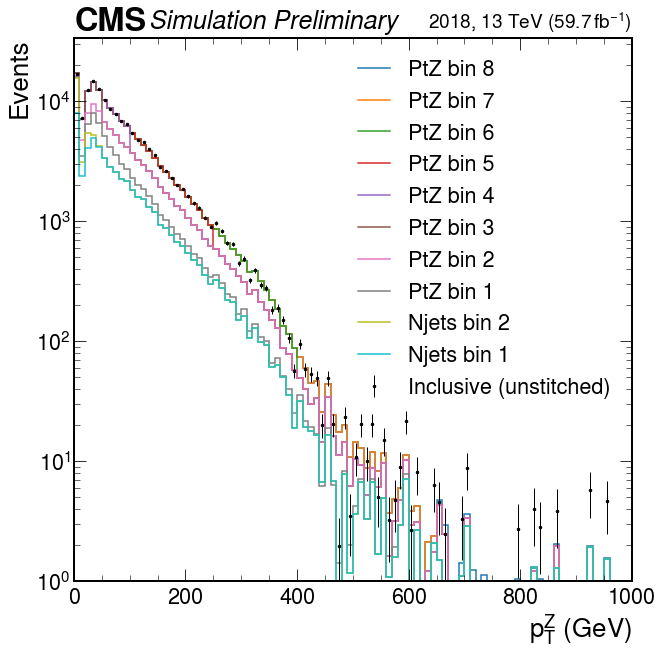

In [46]:
plot_detailed(folder_stitched="/grid_mnt/data__data.polcms/cms/vernazza/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base/prod_240321", folder_notStitched="/grid_mnt/data__data.polcms/cms/vernazza/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base/prod_240320")
plt.savefig("/grid_mnt/data__data.polcms/cms/cuisset/cmt/NicePlots/stitching/dy/2018_detailed.pdf", bbox_inches="tight")